<a id='home'></a>
### purpose 

- create the files that will be needed to run the R script created in `../05_gradient_forest_processing_scripts.ipynb` for all permutations of `loci set x input populations` created here
- in other words, the allele frequency for each loci set and environmental data for each population set will be subset for the populations randomly selected for training (see `../01_split_training_and_testing.ipynb`) and the loci sets created in this notebook


### outline

[1. load allele frequency data](#freqs)
- read in filtered SNP sets in parallel, for each job convert % to float and drop irrelevant columns

[2. load outliers and select random loci two ways (random and pseudo random)](#outliers)
- determine snps found in WZA genes
    - take top 500 ranked WZA genes from each environment, keep loci within genes with Kendall's tau > 0.5 to any environment
        - original submission used 100 genes, but we changed annotations since then. In order to increase total number of loci for the revision, I increased the number of top genes to 500
- get baypass outliers ≥ 15
- get loci that had tau ≤ 0.1 for all envs - this is the non-outlier set
- for the set of loci from wza and baypass, randomly choose the same number of loci from the non-outlier set (a pseudorandom set) and from a truly random set (whole dataset genome wide)
    - pseudorandom set should be what we DONT want to give these offset methods

[3. load environmental data](#envdata)
- load the raw environmental data to get each pop's lat/long

[4. load training data](#training)
- for the populations that were chosen for training sets for each of the kfold cross validations (from `01_split_training_and_testing.ipynb`), subset the frequency data and envdata for these pops
- save these training sets to file

[5. create HPC slurm files to run scripts for each permutation](#slurm)
- create the necessary sbatch.sh files to run scripts


[6. transfer to HPC (cedar)](#cedar)
- rsync all needed files to HPC, execute on HPC

### Notes

- this will need to be rerun to get the WL baypass results (not yet done, probably won't happen)
- models across both varieties of doug-fir were loci from combined snp calling** that intersected with:
    - coastal + interior baypass
    - coastal + interior wza loci
    - except for the random/pseudo random sets which were random with respect to non_outliers and genome wide (ie these were not any deliberate combination of coastal + interior)
    
\** combined snp calling is calling SNPs across both varieties, and implementing filtering as usual (<25% missing data across all pops (both varieties), etc)

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/phenotypic_data/offset_misc_files'

lview,dview = get_client()

latest_commit()
session_info.show()

56 56
##################################################################
Today:	June 09, 2023 - 12:07:25
python version: 3.8.5
conda env: newpy385

Current commit of pythonimports:
commit 03d76f7a992130f4b94ac34a09ad439e918d3044  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 9 09:42:21 2023 -0400
##################################################################



In [2]:
# see end of notebook for run time
t1 = dt.now()

<a id='freqs'></a>
# 1. load allele freqs

- gradient forests wants allele freqs, varscan outputs percentages, convert in parallel

[top](#home)

In [3]:
def frequenize(df):
    """Convert allele freq percent to float."""
    # convert percentage to float
    import pandas 

    locuscol = 'unstitched_locus' if 'unstitched_locus' in df.columns.tolist() else 'locus'
    
    freqcols = [col for col in df.columns if 'FREQ' in col]
    
    df.index = df[locuscol].tolist()
    df = df[freqcols].apply(lambda row: row.str.rstrip("%").astype(float)/100, axis=1)
    df.columns = [col.rstrip(".FREQ") for col in df.columns]

    return df

In [4]:
# these are the full sets of MAF-filtered loci
snp_files = {
    'fdc': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt',
    'fdi': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt',
    'jp': '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt',
    'wl': '/data/projects/pool_seq/WL_genome_tests/WL_psuedo/WL_pseudo_all/snpsANDindels/03_maf-p05_RD-recalculated/WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt',
    'combined': '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/combined_varieties/03_maf-p05_RD-recalculated_both/DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt'
}

In [5]:
# read in each snp file in parallel, each job convert % to float for each allele freq in chunk, throw out all other info
snps = {}
for spp,file in snp_files.items():
    snps[spp] = parallel_read(file,
                              lview=lview,
                              dview=dview,
                              verbose=False,
                              functions=create_fundict(frequenize),
                              reset_index=False)
    print(spp, nrow(snps[spp]))


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:56<00:00,  1.01s/it]


Function `parallel_read` completed after : 0-00:01:09
fdc 2254116

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:00<00:00,  1.08s/it]


Function `parallel_read` completed after : 0-00:01:15
fdi 2483660

Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:28<00:00,  1.94it/s]


Function `parallel_read` completed after : 0-00:00:40
jp 1163236

Watching 56 parallel_read() jobs ...


WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:39<00:00,  1.41it/s]


Function `parallel_read` completed after : 0-00:00:52
wl 1465277

Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [01:36<00:00,  1.71s/it]


Function `parallel_read` completed after : 0-00:01:54
combined 2767766


<a id='outliers'></a>
# 2. load outliers and random loci
- baypass
- wza
- random

[top](#home)

### WZA

First, isolate the top 100 WZA genes for each env, then subset the loci within these genes for any loci with Kendall's tau > 0.5

##### Get WZA genes

In [6]:
# get the wza output
wzadir = '/data/projects/convergence/WZA_allEnvs'

# get environmental files ranking genes
files = fs(wzadir, endswith='.csv', exclude=['CMI', 'DD1040', 'DD18', 'DD_18', 'MAR', 'RH', 'el', 'lat'])
assert len(files) % 19 == 0  # assert 19 files per species/variety

wza_files = defaultdict(dict)
wza_envs = defaultdict(list)
envs = set()
for f in files:
    spp, *env, suffix = op.basename(f).split("_")
    
    if spp.lower() == 'dfc':
        spp = 'fdc'
    if spp.lower() == 'dfi':
        spp = 'fdi'
    
    env = "_".join(env)
    
    envs = set(envs.union({env}))
    
    wza_files[spp.lower()][env] = f
    wza_envs[spp.lower()].append(env)
    
envs = sorted(list(envs))
    
for spp, files in wza_files.items():
    print(spp, len(files))

fdc 19
fdi 19
jp 19
wl 19


In [7]:
len(envs)

19

In [8]:
envs

['AHM',
 'CMD',
 'DD5',
 'DD_0',
 'EMT',
 'EXT',
 'Eref',
 'FFP',
 'MAP',
 'MAT',
 'MCMT',
 'MSP',
 'MWMT',
 'NFFD',
 'PAS',
 'SHM',
 'TD',
 'bFFP',
 'eFFP']

In [9]:
# make sure all envs overlap among files
for i, sppi in enumerate(wza_envs.keys()):
    for j, sppj in enumerate(wza_envs.keys()):
        if i < j:
            print(sppi, sppj, len(set(wza_envs[sppi]).intersection(wza_envs[sppj])))

fdc fdi 19
fdc jp 19
fdc wl 19
fdi jp 19
fdi wl 19
jp wl 19


In [10]:
# get the top 500 WZA genes by taking the prioritizing low values of Z_pVal of the WZA statistic

cutoff = 500  # only keep top 100 genes
count = {}
wza_dfs = defaultdict(dict)
for (spp, env), envfile in unwrap_dictionary(wza_files, progress_bar=True):
    if spp=='fdi':
        spp2 = 'fdi'
    elif spp=='fdc':
        spp2 = 'fdc'
    elif spp=='jp':
        spp2 = spp
    elif spp=='wl':
        spp2 = 'wl'
    if spp in ['dfc', 'dfi']:
        raise Exception("I don't like these labels")

        
    df = pd.read_table(envfile, sep=',')
    
    if spp not in count:
        count[spp] = nrow(df)
    else:
        assert count[spp] == nrow(df)
        
    wza_dfs[spp2][env] = df.sort_values(by='Z_pVal', ascending=True).iloc[:cutoff].reset_index(drop=True)


    
# add to combined (coastal + interior) - use top 500 from each variety
for env, df in wza_dfs['fdc'].items():
    fdidf = wza_dfs['fdi'][env]
    fdcgenes = set(df['index'])
    # if i don't subtract fdcgenes, then the dfs I get back will have duplicated genes
    fdigenes = set(fdidf['index']) - set(fdcgenes)
    cdf = pd.concat(
        [df[df['index'].isin(fdcgenes)],
         fdidf[fdidf['index'].isin(fdigenes)]]
    ).reset_index(drop=True)
    
    assert luni(cdf['index']) == nrow(cdf)
    
    wza_dfs['combined'][env]  = cdf
    
    print(env, nrow(cdf))
    
wza_dfs['combined'][env].head()

100%|███████████████| 4/4 [00:03<00:00,  1.15it/s]

AHM 982
CMD 983
DD5 983
DD_0 979
EMT 978
EXT 978
Eref 977
FFP 980
MAP 980
MAT 979
MCMT 980
MSP 983
MWMT 989
NFFD 979
PAS 982
SHM 987
TD 980
bFFP 986
eFFP 977


,index,SNPs,hits,Z,top_candidate_p,Orthogroup,CHROM,Z_pVal
0,PSME_24276,269.0,11.0,10.283452,1.032503e-04,OG0002864,jcf7190000045144,0.000000e+00
1,PSME_51134,274.0,14.0,7.809656,9.748793e-07,OG0043509,jcf7190000035367,0.000000e+00
2,PSME_09862,287.0,0.0,2.438399,1.000000e+00,OG0005852,jcf7190000044504,0.000000e+00
3,PSME_50037,13.0,7.0,9.052174,1.627888e-11,OG0000146,jcf7190000006878,3.736576e-09
4,PSME_48928,34.0,18.0,12.202710,1.892664e-27,OG0011715,jcf7190000003158,7.684966e-09


In [11]:
# how many genes per group?
for (spp, env), df in unwrap_dictionary(wza_dfs):
    print(spp, env, nrow(df))
    
# before revision:
# combined AHM 198
# combined CMD 198
# combined DD5 198
# combined DD_0 198
# combined EMT 200
# combined EXT 198
# combined Elevation 192
# combined Eref 199
# combined FFP 199
# combined MAP 199
# combined MAT 199
# combined MCMT 199
# combined MSP 198
# combined MWMT 198
# combined NFFD 199
# combined PAS 197
# combined SHM 198
# combined TD 196
# combined bFFP 200
# combined eFFP 200

fdc AHM 500
fdc CMD 500
fdc DD5 500
fdc DD_0 500
fdc EMT 500
fdc EXT 500
fdc Eref 500
fdc FFP 500
fdc MAP 500
fdc MAT 500
fdc MCMT 500
fdc MSP 500
fdc MWMT 500
fdc NFFD 500
fdc PAS 500
fdc SHM 500
fdc TD 500
fdc bFFP 500
fdc eFFP 500
fdi AHM 500
fdi CMD 500
fdi DD5 500
fdi DD_0 500
fdi EMT 500
fdi EXT 500
fdi Eref 500
fdi FFP 500
fdi MAP 500
fdi MAT 500
fdi MCMT 500
fdi MSP 500
fdi MWMT 500
fdi NFFD 500
fdi PAS 500
fdi SHM 500
fdi TD 500
fdi bFFP 500
fdi eFFP 500
jp AHM 500
jp CMD 500
jp DD5 500
jp DD_0 500
jp EMT 500
jp EXT 500
jp Eref 500
jp FFP 500
jp MAP 500
jp MAT 500
jp MCMT 500
jp MSP 500
jp MWMT 500
jp NFFD 500
jp PAS 500
jp SHM 500
jp TD 500
jp bFFP 500
jp eFFP 500
wl AHM 500
wl CMD 500
wl DD5 500
wl DD_0 500
wl EMT 500
wl EXT 500
wl Eref 500
wl FFP 500
wl MAP 500
wl MAT 500
wl MCMT 500
wl MSP 500
wl MWMT 500
wl NFFD 500
wl PAS 500
wl SHM 500
wl TD 500
wl bFFP 500
wl eFFP 500
combined AHM 982
combined CMD 983
combined DD5 983
combined DD_0 979
combined EMT 978
combined EXT 978

In [12]:
# get a list of the unique wza genes across envs (for asserting correct annotation later on)
wza_genes = defaultdict(set)
for (spp, env), df in unwrap_dictionary(wza_dfs):
    if len(wza_genes[spp]) == 0:
        wza_genes[spp] = df['index'].tolist()
    else:
        wza_genes[spp] = set(list(wza_genes[spp]) + df['index'].tolist())
    
for spp, genes in wza_genes.items():
    print(spp, len(genes))
    
# before revision:
# fdc 569
# fdi 661
# jp 483
# wl 731
# combined 1194

fdc 2401
fdi 2774
jp 1975
wl 3239
combined 4776


##### determine loci within WZA genes by annotating loci with gene start/stops

In [13]:
def get_wza_loci(spp):
    """Get loci from WZA genes that have abs(tau) > 0.5 with any env."""
    import pandas as pd
    corrdir = '/data/projects/convergence/correlations/Correlations'
    
    f = f'{corrdir}/{spp}.climatena.clean.csv'
    cor_df = pd.read_table(f, sep=',', usecols=envs + ['CHROM', 'POS', 'gene_ID'], low_memory=False)
    
    cor_df.index = cor_df['CHROM'] + '-' + cor_df['POS'].astype(str)
    
    # the loci in wza genes
    gene_loci = cor_df[cor_df.gene_ID.isin(wza_genes[spp])]
    
    # the loci that have abs(tau) > 0.5 for any env
    loci_df = gene_loci[
        gene_loci[envs].apply(lambda env_taus: (env_taus.abs() > 0.5).any(), axis=1)
    ]
    
    # now overwrite tau score with True or False to indicate env set
    loci_df[envs] = loci_df[envs].abs() > 0.5
    
    return loci_df

dview['envs'] = envs
dview['wza_genes'] = wza_genes

In [14]:
# get wza dfs in parallel
jobs = []
for spp in wza_dfs.keys():
    if spp == 'combined':  # no file for combined, just add two varieties together later on
        continue
        
    jobs.append(
        lview.apply_async(
            get_wza_loci, spp
        )
    )
    
watch_async(jobs)


Watching 4 jobs ...


100%|███████████████| 4/4 [00:57<00:00, 14.25s/it]


In [15]:
# retrieve parallel dfs
wza_loci = {}
for i, spp in enumerate(keys(wza_dfs)):
    if spp == 'combined':
        continue

    wza_loci[spp] = jobs[i].r

    print(spp, len(wza_genes[spp]), nrow(wza_loci[spp]))
    display(wza_loci[spp].head(2))

fdc 2401 3770


,CHROM,POS,gene_ID,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
jcf7190000000596-226265,jcf7190000000596,226265,PSME_46807,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
jcf7190000000596-226519,jcf7190000000596,226519,PSME_46807,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


fdi 2774 1787


,CHROM,POS,gene_ID,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
jcf7190000000037-18788,jcf7190000000037,18788,PSME_41321,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
jcf7190000000125-73057,jcf7190000000125,73057,PSME_12765,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


jp 1975 8564


,CHROM,POS,gene_ID,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
C3778067-411,C3778067,411,PITA_22571,True,False,True,False,False,False,False,False,True,True,False,False,True,False,False,True,False,True,False
C3898871-4973,C3898871,4973,PITA_48292,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


wl 3239 79


,CHROM,POS,gene_ID,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
jcf7190000000692-270237,jcf7190000000692,270237,PSME_51316,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
jcf7190000002074-572582,jcf7190000002074,572582,PSME_14131,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
# create combined file
interloci = list(set(wza_loci['fdc'].index).intersection(wza_loci['fdi'].index))
interdf = wza_loci['fdc'].loc[interloci].copy()
for env in envs:
    for locus in interloci:
        fdi_bool = wza_loci['fdi'][env].loc[locus]
        fdc_bool = wza_loci['fdc'][env].loc[locus]
        interdf.loc[locus, env] = any([fdi_bool, fdc_bool])
        
# combine the loci in the intersection with the variety-specific dataframes
rem_df = pd.concat(
    [
        interdf,
        wza_loci['fdc'][~wza_loci['fdc'].index.isin(interloci)].copy(),
        wza_loci['fdi'][~wza_loci['fdi'].index.isin(interloci)].copy()
    ]
)

assert luni(rem_df.index) == nrow(rem_df)  # make sure no locus duplications

# reduce loci to those that pass cross-variety filtering
print(nrow(rem_df))
rem_df2 = rem_df[rem_df.index.isin(snps['combined'].index)].copy()
print(nrow(rem_df2))

wza_loci['combined'] = rem_df2
print('combined', len(wza_genes['combined']), nrow(wza_loci['combined']))

5550
4810
combined 4776 4810


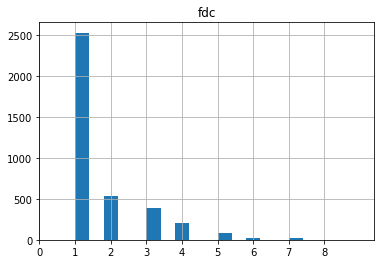

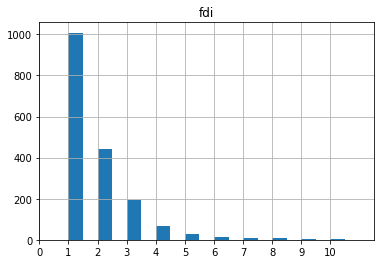

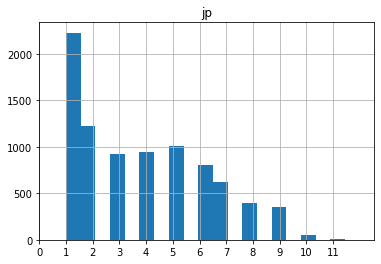

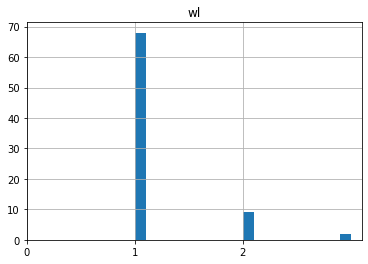

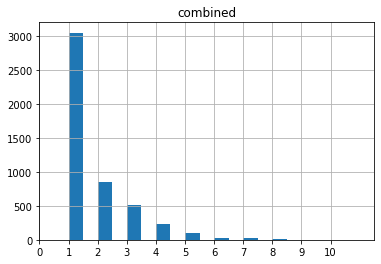

In [17]:
# how many times was a given gene associated to X number of envs? 
# - this actually counts loci, not genes (but loci are within genes so shape of hist should be consistent)
for spp, locidf in wza_loci.items():
    locidf['sums'] = locidf[envs].apply(lambda env_bools: env_bools.sum(), axis=1)
    
    locidf['sums'].hist(bins=20)
    plt.title(spp)
    try:
        plt.xticks(range(0,
                         locidf['sums'].max(),
                         1))
    except TypeError as e:
        fail_msg = f'******* error for {spp} *******'
        border = '*' * len(fail_msg)
        print(ColorText(f'{border}\n{fail_msg}\n{border}').fail().bold())
    plt.show()

In [18]:
# translate WL stitched to unstitched position (wza team accidentally used stitched position)

def translate(df):
    """Translate WL stitched to unstitched locus names."""
    return dict(zip(df['locus'], df['unstitched_locus']))

dicts = parallel_read(
    snp_files['wl'],
    lview=lview,
    dview=dview,
    verbose=False,
    maintain_dataframe=False,
    functions=create_fundict(translate)
)

wl_trans = {}
counts = 0
for d in dicts:
    wl_trans.update(d)
    counts += len(d)
    
len(wl_trans), counts


Watching 56 parallel_read() jobs ...


WL_pseudo-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt: 100%|███████████████| 56/56 [00:18<00:00,  3.05it/s]


Function `parallel_read` completed after : 0-00:00:30


(1465277, 1465277)

In [19]:
wza = {}
for spp, df in wza_loci.items():
    loci = df.index
    
    # edit the name of some loci
    if spp in ['jp', 'wl']:
        loci = '>' + loci
    
    # make sure all loci names are in the snp tables
    x = snps[spp].loc[loci]
    
    wza[spp] = list(loci)
    
    print(spp, len(wza[spp]))
    
# before revision
# fdc 4886
# fdi 11434
# jp 4788
# wl 8496
# combined 14760

fdc 3770
fdi 1787
jp 8564
wl 79
combined 4810


### non-outliers (pseudo random)

- these are loci that have kendall's tau < 0.1 for ALL envs
- I'll choose randomly among these loci to match sample sizes in WZA (above) and baypass (below)
- truly random loci (without respect to outlier status) are chosen after baypass below

In [20]:
# def get_non_outliers(tau_table):
#     """Return only loci that have Kendall's Tau < 0.1.
    
#     `tau_table` is the input to the WZA test.
#     """
#     return tau_table[tau_table['kendallstau'] < 0.1]

# # my 20 envs that I'm using to train gradient forest
# envs = ['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP',
#         'MAT', 'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']
# assert len(envs) == 20


# non_outliers = {}
# for spp,d in zip(['fdc', 'fdi', 'jp', 'wl'], wzadirs):
#     files = fs(d, pattern='kendallstau')
#     assert len(files) == 1
    
#     # read in kendall's tau results
#     taudf = parallel_read(files[0],
#                           lview=lview,
#                           dview=dview,
#                           verbose=False,
#                           assert_rowcount=False,
#                           functions=create_fundict(get_non_outliers),
#                           desc=spp)

#     # make sure all 20 envs are in the df, reduce tau results to only those envs
#     assert sum(pd.Series(envs).isin(taudf['env'])) == 20
#     taudf = taudf[taudf['env'].isin(envs)]
    
#     # find loci that have low tau across all envs
#     # (if tau < 0.1 for a locus for all envs, a locus should occur 20 times in the full filtered tau_table 
#         # - I have 20 envs)
#     locus_counter = Counter(taudf['snp'])
#     low_tau = [locus for (locus,count) in locus_counter.items() if count == 20]
    
#     # clean up locus names
#     if spp in ['jp', 'wl']:
#         # append '>' before locus name
#         low_tau = ['>' + locus for locus in low_tau]
#     if spp == 'wl':
#         # translate to unstitched positions - wza team used stitched
#         low_tau = [wl_trans[locus.replace('>', '')] for locus in low_tau]
        
#     # make sure numbers make sense - I should be able to find all of the outliers in the snp table
#         # this will ensure that they should be in the annotated loci that fall within WZA genes
#     assert len(set(low_tau).intersection(snps[spp].index)) == luni(low_tau)
    
#     non_outliers[spp] = uni(low_tau)
#     print(spp, len(non_outliers[spp]))
    

# # combine coastal and interior, reduce to those SNPs called across varieities    
# non_outliers['combined'] = list(set(
#     non_outliers['fdi'] + non_outliers['fdc']
# ).intersection(snps['combined'].index.tolist()))
# print('combined', len(non_outliers['combined']))

In [21]:
# non_copy = copy.deepcopy(non_outliers)

### baypass

for each species
- get lists of baypass outliers with mean_BF(dB) ≥ 15

In [22]:
def find_outliers(spp, pkl):
    """For a given species, get baypass outliers with mean_BF ≥ 15.
    
    Also get non-outliers for loci with mean_BF < 1 for ALL envs.
    
    Notes
    -----
    - each pkl is a dictionary with keys for environment and values as baypass output
        - these files were created in each species' baypass/gather notebook
    """
    from pythonimports import pklload, uni
    from tqdm import tqdm as pbar
    
    results = pklload(pkl)
    
    outliers = []  # loci that have BF ≥ 15 for any of the envs
    for i, (env,df) in enumerate(pbar(results.items())):
        gte15 = df.index[df['mean_BF(dB)'] >= 15].tolist()  # greater than or equal to 15
        outliers.extend(gte15)
        
    outliers = uni(outliers)
    
    return spp, outliers

In [23]:
# get outlier sets in parallel
jobs = []
for spp, file in snp_files.items():
    if spp in ['wl', 'combined']:
        # no baypass results
        continue

    d = op.dirname(file)
    pkl = op.join(d, 'baypass/final_results/envdfs_after_ranking.pkl')
    
    jobs.append(
        lview.apply_async(
            find_outliers, *(spp, pkl)
        )
    )
    
watch_async(jobs)

# retrieve parallel job info
print('spp cands')
baypass = {}
for j in jobs:
    spp, candidates = j.r
    baypass[spp] = candidates
    print(spp, len(candidates))
    
# combine coastal and interior, reduce to those SNPs called across varieties
spp = 'combined'
baypass[spp] = list(set(
    baypass['fdc'] + baypass['fdi']
).intersection(snps[spp].index.tolist()))
print(spp, len(baypass[spp]))

# before revision
# spp cands
# fdc 17516
# fdi 12398
# jp 22635
# combined 25219


Watching 3 jobs ...


100%|███████████████| 3/3 [00:56<00:00, 18.89s/it]


spp cands
fdc 17516
fdi 12398
jp 22635
combined 25219


In [24]:
# compare with wza
for spp, loci in wza.items():
    print(spp, len(loci))
    
# before revision
# fdc 4886
# fdi 11434
# jp 4788
# wl 8496

fdc 3770
fdi 1787
jp 8564
wl 79
combined 4810


In [25]:
keys(baypass)

['fdc', 'fdi', 'jp', 'combined']

In [26]:
keys(wza)

['fdc', 'fdi', 'jp', 'wl', 'combined']

### pseudo random loci (randomly chosen among non-outliers)
random non-outlier loci sets of the same size as wza and baypass

In [27]:
# # previously set seeds (i may add in wl_baypass at a later date, and I like to rerun notebooks some times)
# seeds = {
#     'pseudo': {
#         'fdc_baypass' : 116297,
#         'fdi_baypass' : 100096,
#         'jp_baypass' : 261763,
#         'fdc_wza' : 6096,
#         'fdi_wza' : 161898,
#         'jp_wza' : 184965,
#         'wl_wza' : 272713
#     },
#     'random': {
#         'fdc_baypass' : 43196,
#         'fdi_baypass' : 478266,
#         'jp_baypass' : 14771,
#         'fdc_wza' : 32646,
#         'fdi_wza' : 126925,
#         'jp_wza' : 257765,
#         'wl_wza' : 118895
        
#     }
# }

In [28]:
# non_outliers = copy.deepcopy(non_copy)

In [29]:
# the number of random sets of loci per species equals the number of outlier methods
random_sizes = defaultdict(list)
for method, candidates in zip(['baypass', 'wza'], [baypass, wza]):
    for spp, loci in candidates.items():
        random_sizes[f'{spp}_{method}'].append(len(loci))
# del spp

# # for each species choose random loci among the non-outlier
# pseudo_random_loci = defaultdict(list)
# for spp_method,set_sizes in random_sizes.items():
#     loci = list(non_candidates[spp_method.split('_')[0]])
#     for i,set_size in enumerate(set_sizes):
#         if spp_method in keys(seeds['pseudo']):
#             seed = seeds['pseudo'][spp_method]
#         else:
#             seed = random.randint(0, 500000)
#         print(spp_method, set_size, seed)
#         random.Random(seed).shuffle(loci)
#         pseudo_random_loci[spp_method].append(loci[:set_size])
#         assert set_size == len(pseudo_random_loci[spp_method][i])

In [30]:
keys(random_sizes)

['fdc_baypass',
 'fdi_baypass',
 'jp_baypass',
 'combined_baypass',
 'fdc_wza',
 'fdi_wza',
 'jp_wza',
 'wl_wza',
 'combined_wza']

### random sets (random without respect to outlier status)

In [31]:
keys(random_sizes)

['fdc_baypass',
 'fdi_baypass',
 'jp_baypass',
 'combined_baypass',
 'fdc_wza',
 'fdi_wza',
 'jp_wza',
 'wl_wza',
 'combined_wza']

In [32]:
seeds = {
    'pseudo': {
        'fdc_baypass' : 116297,
        'fdi_baypass' : 100096,
        'jp_baypass' : 261763,
        'fdc_wza' : 6096,
        'fdi_wza' : 161898,
        'jp_wza' : 184965,
        'wl_wza' : 272713
    },
    'random': {
        'fdc_baypass' : 43196,
        'fdi_baypass' : 478266,
        'jp_baypass' : 14771,
        'fdc_wza' : 32646,
        'fdi_wza' : 126925,
        'jp_wza' : 257765,
        'wl_wza' : 118895,
        'combined_baypass' : 191988,  # added for revision (this was printed out)
        'combined_wza' : 128528  # added for revision (this was printed out)
        
    }
}

In [33]:
random_loci = defaultdict(list)
for spp, set_sizes in random_sizes.items():
    loci = snps[spp.split("_")[0]].index.tolist()
    
    for i, set_size in enumerate(set_sizes):
#         if spp not in keys(seeds['random']):
#             seed = random.randint(0, 500000)
#         else:
#             seed = seeds['random'][spp]
            
        seed = seeds['random'][spp]  # use 
            
        print(spp, set_size, seed)
        
        random.Random(seed).shuffle(loci)
        random_loci[spp].append(loci[:set_size])
        
        assert set_size == len(random_loci[spp][i])
        
# before revision
# fdc_baypass 17516 43196
# fdi_baypass 12398 478266
# jp_baypass 22635 14771
# combined_baypass 25219 191988
# fdc_wza 4886 32646
# fdi_wza 11434 126925
# jp_wza 4788 257765
# wl_wza 8496 118895
# combined_wza 14760 128528

fdc_baypass 17516 43196
fdi_baypass 12398 478266
jp_baypass 22635 14771
combined_baypass 25219 191988
fdc_wza 3770 32646
fdi_wza 1787 126925
jp_wza 8564 257765
wl_wza 79 118895
combined_wza 4810 128528


### subset allele freqs to the loci sets

In [34]:
# BF ≥ 15
# wza
# random

In [35]:
loci_sets = {'baypass' : baypass,
             'wza' : wza,
             'random' : random_loci}#,
#              'pseudo_random_loci' : pseudo_random_loci}

In [36]:
# get allele freqs for loci in loci_sets
freq_sets = {}
for _method,loci_set in loci_sets.items():
    for spp,loci in loci_set.items():
        # fix naming convention
        method = _method
        if '_' in spp:
            full = False
            spp,setname = spp.split("_")
            method,setname = setname,method
            if method == 'random':
                method = 'random_loci'
        else:
            full = True
            setname = 'real'
            
        # get a list of loci
        if 'random' in setname:
            assert len(loci) == 1
            df = snps[spp.split("_")[0]].loc[loci[0]]
        else:
            df = snps[spp.split("_")[0]].loc[loci]
        # save to dict
        key = f"{spp}-{method}-{setname}"
        freq_sets[key] = df.copy()
        
        print(key, nrow(df))
    print('\n')
    
# before revision
# fdc-baypass-real 17516
# fdi-baypass-real 12398
# jp-baypass-real 22635
# combined-baypass-real 25219

# fdc-wza-real 4886
# fdi-wza-real 11434
# jp-wza-real 4788
# wl-wza-real 8496
# combined-wza-real 14760

# fdc-baypass-random 17516
# fdi-baypass-random 12398
# jp-baypass-random 22635
# combined-baypass-random 25219
# fdc-wza-random 4886
# fdi-wza-random 11434
# jp-wza-random 4788
# wl-wza-random 8496
# combined-wza-random 14760

# fdc-baypass-pseudo_random_loci 17516
# fdi-baypass-pseudo_random_loci 12398
# jp-baypass-pseudo_random_loci 22635
# combined-baypass-pseudo_random_loci 25219
# fdc-wza-pseudo_random_loci 4886
# fdi-wza-pseudo_random_loci 11434
# jp-wza-pseudo_random_loci 4788
# wl-wza-pseudo_random_loci 8496
# combined-wza-pseudo_random_loci 14760

fdc-baypass-real 17516
fdi-baypass-real 12398
jp-baypass-real 22635
combined-baypass-real 25219


fdc-wza-real 3770
fdi-wza-real 1787
jp-wza-real 8564
wl-wza-real 79
combined-wza-real 4810


fdc-baypass-random 17516
fdi-baypass-random 12398
jp-baypass-random 22635
combined-baypass-random 25219
fdc-wza-random 3770
fdi-wza-random 1787
jp-wza-random 8564
wl-wza-random 79
combined-wza-random 4810




<a id='envdata'></a>
# 3. load envdata

[top](#home)

In [37]:
# envdata files
env_files = {'fdi' : '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt',
             'fdc' : '/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt',
             'jp' : '/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt',
             'wl' : '/data/projects/pool_seq/environemental_data/wl_raw_env-19variables_45pops.txt',
             'combined' : '/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt'
            }

In [38]:
# read in envdata
envdata = {}
for spp, file in env_files.items():
    envdata[spp] = pd.read_table(file)
    envdata[spp].index = envdata[spp]['our_id'].tolist()
envdata[spp].head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,8.4,15.6,2.3,13.3,4004,778,4.6,20.0,143,1644,277,115,301,186,242,-18.3,33.3,606,10
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,6.1,16.4,-4.4,20.8,1029,225,15.6,73.0,518,1521,202,135,272,137,330,-30.9,35.2,659,307
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,1.6,13.4,-10.7,24.1,630,321,18.5,41.8,1242,929,130,171,244,73,261,-43.3,32.6,548,151
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,3.9,15.3,-9.2,24.5,423,196,32.9,78.2,919,1270,158,154,255,101,149,-40.2,34.9,598,350
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,6.0,17.7,-6.2,23.9,367,171,43.8,103.6,637,1650,182,142,265,123,100,-34.8,37.7,732,497


In [39]:
# the envs I care about
assert len(envs) == 19  # 19 climatic variables
print(envs)

['AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT', 'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']


<a id='training'></a>
# 4. load training/test sets, remove non-training pops from loci sets

also keep one full set

[top](#home)

In [40]:
# load training/test sets - True if pop is in training set else False
# created in ../01_split_training_and_testing.ipynb
training_df = pklload(op.join(DIR, 'train_test_assignment_for_kfold_crossval.pkl'))
keys(training_df)

['fdc', 'fdi', 'combined', 'jp', 'wl']

In [41]:
training_df['fdc'].head()

,k1 training,k2 training,k3 training,k4 training
DF_p1,True,True,False,True
DF_p2,True,True,True,False
DF_p6,True,False,True,True
DF_p10,True,True,True,False
DF_p11,True,True,False,True


In [42]:
colors = {'fdc': 'lime',
          'fdi' : 'purple',
          'jp' : 'green',
          'wl' : 'blue',
          'combined' : 'red'
         }

In [43]:
keys(loci_sets)

['baypass', 'wza', 'random']

In [44]:
df = training_df['fdc']
for training_set in df.columns:
    kfold = training_set.split(' ')[0]
    print(kfold)

k1
k2
k3
k4


In [45]:
# create training data sets - one for each kfold, and one 'full' model using all pops
training_data = defaultdict(dict)
training_climate = defaultdict(dict)


for dataset, dataset_freqs in freq_sets.items():
    print(ColorText('\n\n------ CROSS VALIDATION ------').bold())
    
    spp,method,setname = dataset.split("-")
    print(ColorText(f'\n{spp}').bold().custom(colors[spp]))
    # get kfold training assignments
    df = training_df[spp]
    
    
    # create training data for each kfold
    for training_set in df.columns:
        # create cross-validation dataset
        kfold = training_set.split(' ')[0]
        training_pops = df[df[training_set] == True].index.tolist()
        training_data[dataset][kfold] = dataset_freqs[training_pops].T  # transpose so pops are rows
        training_climate[dataset][kfold] = envdata[spp][envs].loc[training_pops]  # pops already are rows
        assert all(training_data[dataset][kfold].index == training_climate[dataset][kfold].index)
        print(dataset, kfold, training_data[dataset][kfold].shape, training_climate[dataset][kfold].shape)
        
    # create full datasets
    print(ColorText('\n------ FULL DATSETS ------').bold())
    training_climate[dataset]['full'] = envdata[spp][envs]
    training_data[dataset]['full'] = dataset_freqs.T.loc[envdata[spp].index]
    assert all(training_data[dataset]['full'].index == training_climate[dataset]['full'].index)
    print(dataset, 'full', training_data[dataset]['full'].shape, training_climate[dataset]['full'].shape)

training_data = dict(training_data)
training_climate = dict(training_climate)



------ CROSS VALIDATION ------

fdc
fdc-baypass-real k1 (28, 17516) (28, 19)
fdc-baypass-real k2 (28, 17516) (28, 19)
fdc-baypass-real k3 (29, 17516) (29, 19)
fdc-baypass-real k4 (29, 17516) (29, 19)

------ FULL DATSETS ------
fdc-baypass-real full (38, 17516) (38, 19)


------ CROSS VALIDATION ------

fdi
fdi-baypass-real k1 (26, 12398) (26, 19)
fdi-baypass-real k2 (26, 12398) (26, 19)
fdi-baypass-real k3 (26, 12398) (26, 19)
fdi-baypass-real k4 (27, 12398) (27, 19)

------ FULL DATSETS ------
fdi-baypass-real full (35, 12398) (35, 19)


------ CROSS VALIDATION ------

jp
jp-baypass-real k1 (26, 22635) (26, 19)
jp-baypass-real k2 (26, 22635) (26, 19)
jp-baypass-real k3 (26, 22635) (26, 19)

------ FULL DATSETS ------
jp-baypass-real full (39, 22635) (39, 19)


------ CROSS VALIDATION ------

combined
combined-baypass-real k1 (54, 25219) (54, 19)
combined-baypass-real k2 (55, 25219) (55, 19)
combined-baypass-real k3 (55, 25219) (55, 19)
combined-baypass-real k4 (55, 25219) (55, 19)


In [46]:
for dataset,kdict in training_climate.items():
    print(dataset)
    for k,envdf in kdict.items():
        print('\t', k)

fdc-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
fdi-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
jp-baypass-real
	 k1
	 k2
	 k3
	 full
combined-baypass-real
	 k1
	 k2
	 k3
	 k4
	 full
fdc-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
fdi-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
jp-wza-real
	 k1
	 k2
	 k3
	 full
wl-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
combined-wza-real
	 k1
	 k2
	 k3
	 k4
	 full
fdc-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
fdi-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
jp-baypass-random
	 k1
	 k2
	 k3
	 full
combined-baypass-random
	 k1
	 k2
	 k3
	 k4
	 full
fdc-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
fdi-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
jp-wza-random
	 k1
	 k2
	 k3
	 full
wl-wza-random
	 k1
	 k2
	 k3
	 k4
	 full
combined-wza-random
	 k1
	 k2
	 k3
	 k4
	 full


# Save

### first, make sure the new files are exactly like the old files (unless 'combined')

In [47]:
# save training files
def write_datafile(file, df, reset_index=False, index=True, dry_run=False, index_col=None):
    df = df.copy()
    if reset_index is True:
        # convert index to column named 'index'
        df.reset_index(inplace=True, drop=False)     
        index = False
    
    df.to_csv(file, sep='\t', index=index, header=True)
    
    pass

In [48]:
# make sure training files are the same as last time
training_dir = makedir(op.join(DIR, 'training/training_files'))

def finish_files():
    freq_files = []
    envdata_files = []
    for dataset, kfolds in training_data.items():
        if isinstance(kfolds, pd.DataFrame):  # if it's the full dataset
            freqfile = op.join(training_dir, f'{dataset}.txt')
            freq_files.append(freqfile)
            write_datafile(freqfile, kfolds, reset_index=True)

            envfile = op.join(training_dir, f'{dataset}_envdata.txt')
            write_datafile(envfile, training_climate[dataset])
    #         print(freqfile, '\n', envfile)

        else:  # else it's one of the cross-validation sets
            for kfold,freqs in pbar(kfolds.items(), desc=dataset):
                freqfile = op.join(training_dir, f'{dataset}-{kfold}.txt')
                freq_files.append(freqfile)
                write_datafile(freqfile, freqs, reset_index=True)

                envfile = op.join(training_dir, f'{dataset}-{kfold}_envdata.txt')
                envdata_files.append(envfile)
    #             print(freqfile, '\n', envfile)
                write_datafile(envfile, training_climate[dataset][kfold])
    return freq_files,envdata_files

### save training files for real

In [49]:
# write to file
freqfiles, envdata_files = finish_files()

combined-wza-random: 100%|███████████████| 5/5 [00:01<00:00,  4.27it/s]


In [50]:
assert len(freqfiles) == luni(freqfiles)
assert len(envdata_files) == luni(envdata_files)

In [51]:
envdata_files

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k1_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k2_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k3_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k4_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-full_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k1_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k2_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k3_envdata.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_

In [52]:
freqfiles

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k1.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k2.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k3.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-k4.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdc-baypass-real-full.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k1.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k2.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k3.txt',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files/fdi-baypass-real-k4.txt',
 '/data/

<a id='slurm'></a>
# 5. create slurm files

[top](#home)

In [53]:
# files created in ../03_clip_climate_data.ipynb
range_files = {'fdc' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt',
               'fdi' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_interior.txt',
               'jp' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_jp.txt',
               'wl' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_wl.txt',
               'combined' : '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_combined.txt'
              }
assert all([op.exists(f) for f in range_files.values()])

In [54]:
DIR

'/data/projects/pool_seq/phenotypic_data/offset_misc_files'

In [55]:
# create sbatch .sh files
cdir = '/scratch/lindb/gradient_forest_iterations'  # remote path

# move previously created files from before revision (these shouldn't change though except for email)
shdir = makedir(op.join(DIR, 'training/training_shfiles'))
tmpdir = makedir(op.join(shdir, 'before_revision'))
for src in fs(shdir, dirs=False):
    # save previous files
    dst = op.join(tmpdir, op.basename(src))
    shutil.move(src, dst)
imports_path = '/home/lindb/github/r_imports'  # remote path

# create sh files
shfiles = []
for snpfile in freqfiles:
    snpfile = snpfile.replace(DIR, cdir)  # remote path
    spp = op.basename(snpfile).split('_')[0].split("-")[0]
    
    envfile = snpfile.replace('.txt', '_envdata.txt')  # remote path
    rangefile = op.join(cdir, 'training/training_files/' + op.basename(range_files[spp]))  # remote path
    basename = op.basename(snpfile.rstrip('.txt'))
    
    text = f'''#!/bin/sh
#SBATCH --job-name={basename}
#SBATCH --time=12:00:00
#SBATCH --mem=120000M
#SBATCH --output={basename}_%j.out
#SBATCH --mail-user=lind.brandon.m@gmail.com
#SBATCH --mail-type=FAIL

module load nixpkgs/16.09  gcc/7.3.0 r/3.5.1
export R_LIBS=~/.local/R/$EBVERSIONR

Rscript {cdir}/gradient_training.R \\
{snpfile} \\
{envfile} \\
{rangefile} \\
{basename} \\
{cdir} \\
{imports_path}


'''
    shfile = op.join(shdir, basename + '.sh')
    with open(shfile, 'w') as o:
        o.write(text)
    shfiles.append(shfile)
    
len(shfiles)

86

In [56]:
shfiles[:5]

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k1.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k2.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k3.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-k4.sh',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_shfiles/fdc-baypass-real-full.sh']

In [57]:
print(read(shfiles[0], lines=False))

#!/bin/sh
#SBATCH --job-name=fdc-baypass-real-k1
#SBATCH --time=12:00:00
#SBATCH --mem=120000M
#SBATCH --output=fdc-baypass-real-k1_%j.out
#SBATCH --mail-user=lind.brandon.m@gmail.com
#SBATCH --mail-type=FAIL

module load nixpkgs/16.09  gcc/7.3.0 r/3.5.1
export R_LIBS=~/.local/R/$EBVERSIONR

Rscript /scratch/lindb/gradient_forest_iterations/gradient_training.R \
/scratch/lindb/gradient_forest_iterations/training/training_files/fdc-baypass-real-k1.txt \
/scratch/lindb/gradient_forest_iterations/training/training_files/fdc-baypass-real-k1_envdata.txt \
/scratch/lindb/gradient_forest_iterations/training/training_files/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt \
fdc-baypass-real-k1 \
/scratch/lindb/gradient_forest_iterations \
/home/lindb/github/r_imports





<a id='cedar'></a>
# 6. transfer to cedar HPC

[top](#home)

In [58]:
cdir

'/scratch/lindb/gradient_forest_iterations'

In [59]:
script_files = fs(DIR, endswith='.R')
script_files

['/data/projects/pool_seq/phenotypic_data/offset_misc_files/extract_importance.R',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_fitting_script.R',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_training.R']

In [60]:
# which dirs to make on cedar so that rsync commands work?
dnames = []
for src in freqfiles + envdata_files + script_files + shfiles:
    dst = src.replace(DIR, 'cedar:' + cdir)
    dnames.append(op.dirname(dst))
    
for src in values(range_files):
    dst = src.replace(op.dirname(src), 'cedar:' + cdir)
    dnames.append(op.dirname(dst))
    
uni(dnames)

['cedar:/scratch/lindb/gradient_forest_iterations',
 'cedar:/scratch/lindb/gradient_forest_iterations/training/training_shfiles',
 'cedar:/scratch/lindb/gradient_forest_iterations/training/training_files']

In [61]:
jobs = []
srcdsts = []
for src in freqfiles + envdata_files + script_files + shfiles:
    dst = src.replace(DIR, 'cedar:' + cdir)
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
for src in values(range_files):
    dst = src.replace(op.dirname(src), 'cedar:' + op.join(cdir, 'training/training_files'))
    jobs.append(lview.apply_async(rsync, *(src, dst)))
    srcdsts.append((src, dst))
    
watch_async(jobs)


Watching 266 jobs ...


100%|███████████████| 266/266 [03:05<00:00,  1.43it/s]


In [62]:
count = 0
while True:
    needed = []
    newlist = []
    for i,j in enumerate(jobs):
        try:
            x = j.r
        except:
            needed.append(srcdsts[i])
            newlist.append(srcdsts[i])
    srcdsts = newlist
    
    if len(needed) == 0:
        break
    
    jobs = []
    for src,dst in needed:
        jobs.append(lview.apply_async(rsync, *(src, dst)))
    watch_async(jobs, desc=f'iteration {count}')
    
    count += 1



Watching 4 jobs ...


iteration 0: 100%|███████████████| 4/4 [00:12<00:00,  3.03s/it]


In [63]:
# total time to complete notebook
t2 = dt.now()
formatclock(t2 - t1, exact=True)

'0-00:12:44'

In [64]:
# now go to the server and sbatch the .sh files!

[top](#home)